In [169]:
import argparse
from pprint import pprint

import numpy as np
from keras.datasets import cifar10
from keras.utils import to_categorical
from matplotlib import pyplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Multiply, Concatenate
from tensorflow.keras.optimizers import Adam

In [170]:
def summarise_diagnostics(history):
    # plot accuracy
    pyplot.subplot(211)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Accuracy')

    # plot loss
    pyplot.subplot(212)
    pyplot.title('Mean Squared Error Loss')
    pyplot.plot(history.history['loss'], color='orange', label='train')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Loss')

    pyplot.tight_layout()
    pyplot.show()


In [171]:
from keras import backend as K
from tensorflow.keras.layers import Layer


class FuzzyLayer(Layer):

    def __init__(self, output_dim, initialiser_centers=None, initialiser_sigmas=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        self.initialiser_centers = initialiser_centers
        self.initialiser_sigmas = initialiser_sigmas
        super(FuzzyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.fuzzy_degree = self.add_weight(name='fuzzy_degree',
                                            shape=(input_shape[-1], self.output_dim),
                                            initializer=self.initialiser_centers if self.initialiser_centers is not None else 'uniform',
                                            trainable=True)
        self.sigma = self.add_weight(name='sigma',
                                     shape=(input_shape[-1], self.output_dim),
                                     initializer=self.initialiser_sigmas if self.initialiser_sigmas is not None else 'ones',
                                     trainable=True)
        super(FuzzyLayer, self).build(input_shape)

    def call(self, input, **kwargs):
        x = K.repeat_elements(K.expand_dims(input, axis=-1), self.output_dim, -1)

        fuzzy_out = K.exp(-K.sum(K.square((x - self.fuzzy_degree) / (self.sigma ** 2)), axis=-2, keepdims=False))
        return fuzzy_out

    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)


In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
def func(name,x,y):
    inv = 0

    if name == 'StandardScaler':
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
        x = x_scaled
        y = y_scaled
        inv = scaler

    if name == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
        x = x_scaled
        y = y_scaled
        inv = scaler

    return x, y, inv

In [173]:
import pandas as pd
df = pd.read_csv("/Users/rahuljauhari/Desktop/research-runoff/Data/merged_imd.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.iloc[:, :157]

df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)
monthly_mean = df.resample('M').mean()
print(monthly_mean.shape)

df_actual = pd.read_excel("/Users/rahuljauhari/Desktop/research-runoff/Data/Calibrated and Validated.xlsx")
# select last column
observed_runnoff = df_actual['observed']
# observed_runnoff.head()
print(observed_runnoff.shape)

(468, 156)
(468,)


In [174]:

parameters = argparse.Namespace()
parameters.membership_layer_units = 10
parameters.dr_layer_1_units = 32
parameters.dr_layer_2_units = 32
parameters.lstm=32
parameters.fusion_dr_layer_units = 10
parameters.learning_rate = 0.001
parameters.epochs = 100
parameters.batch_size = 32


In [175]:
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply,LSTM, Dropout,Maximum
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [176]:
# fist is tht input layer then followed by lstm layer
def prepare_model(parameters):
    
    input_layer = Input(shape=(156, 1))
    
    lstm_layer = LSTM(parameters.lstm)(input_layer)
    
    fuzz_membership_layer = []
    
    # membership layer
    membership_layer = FuzzyLayer(parameters.membership_layer_units)(lstm_layer)
    fuzz_membership_layer.append(membership_layer) 
    
    # dropout layer
    rule_layer = Multiply()(fuzz_membership_layer) 
    dense_layer_1 = Dense(parameters.dr_layer_1_units, activation='selu')(membership_layer)
    dropout_layer_1 = Dropout(0.2)(dense_layer_1)

    # dense layer
    dense_layer_1 = Dense(parameters.dr_layer_1_units, activation='selu')(dropout_layer_1)

    # fusion layer
    fusion_layer = Concatenate()([rule_layer, membership_layer]) 
    fusion_layer = Dense(parameters.fusion_dr_layer_units, activation='selu')(fusion_layer)

    # output layer
    output_layer = Dense(1, activation='LeakyReLU')(fusion_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(lr=parameters.learning_rate), metrics=['accuracy'])
    return model


In [177]:
from sklearn.model_selection import train_test_split
x,y,inv = func('StandardScaler',monthly_mean,observed_runnoff)
print(x.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2)

num_classes = y_test.shape[-1]
input_length = len(X_train)
input_shape = X_train[0].shape[-1]
model = prepare_model(parameters)
# to model_summary.txt
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))


(468, 156)
(468, 1)


In [178]:
history = model.fit(X_train, y_train, epochs=parameters.epochs, batch_size=parameters.batch_size,validation_split=0.1,verbose=0)


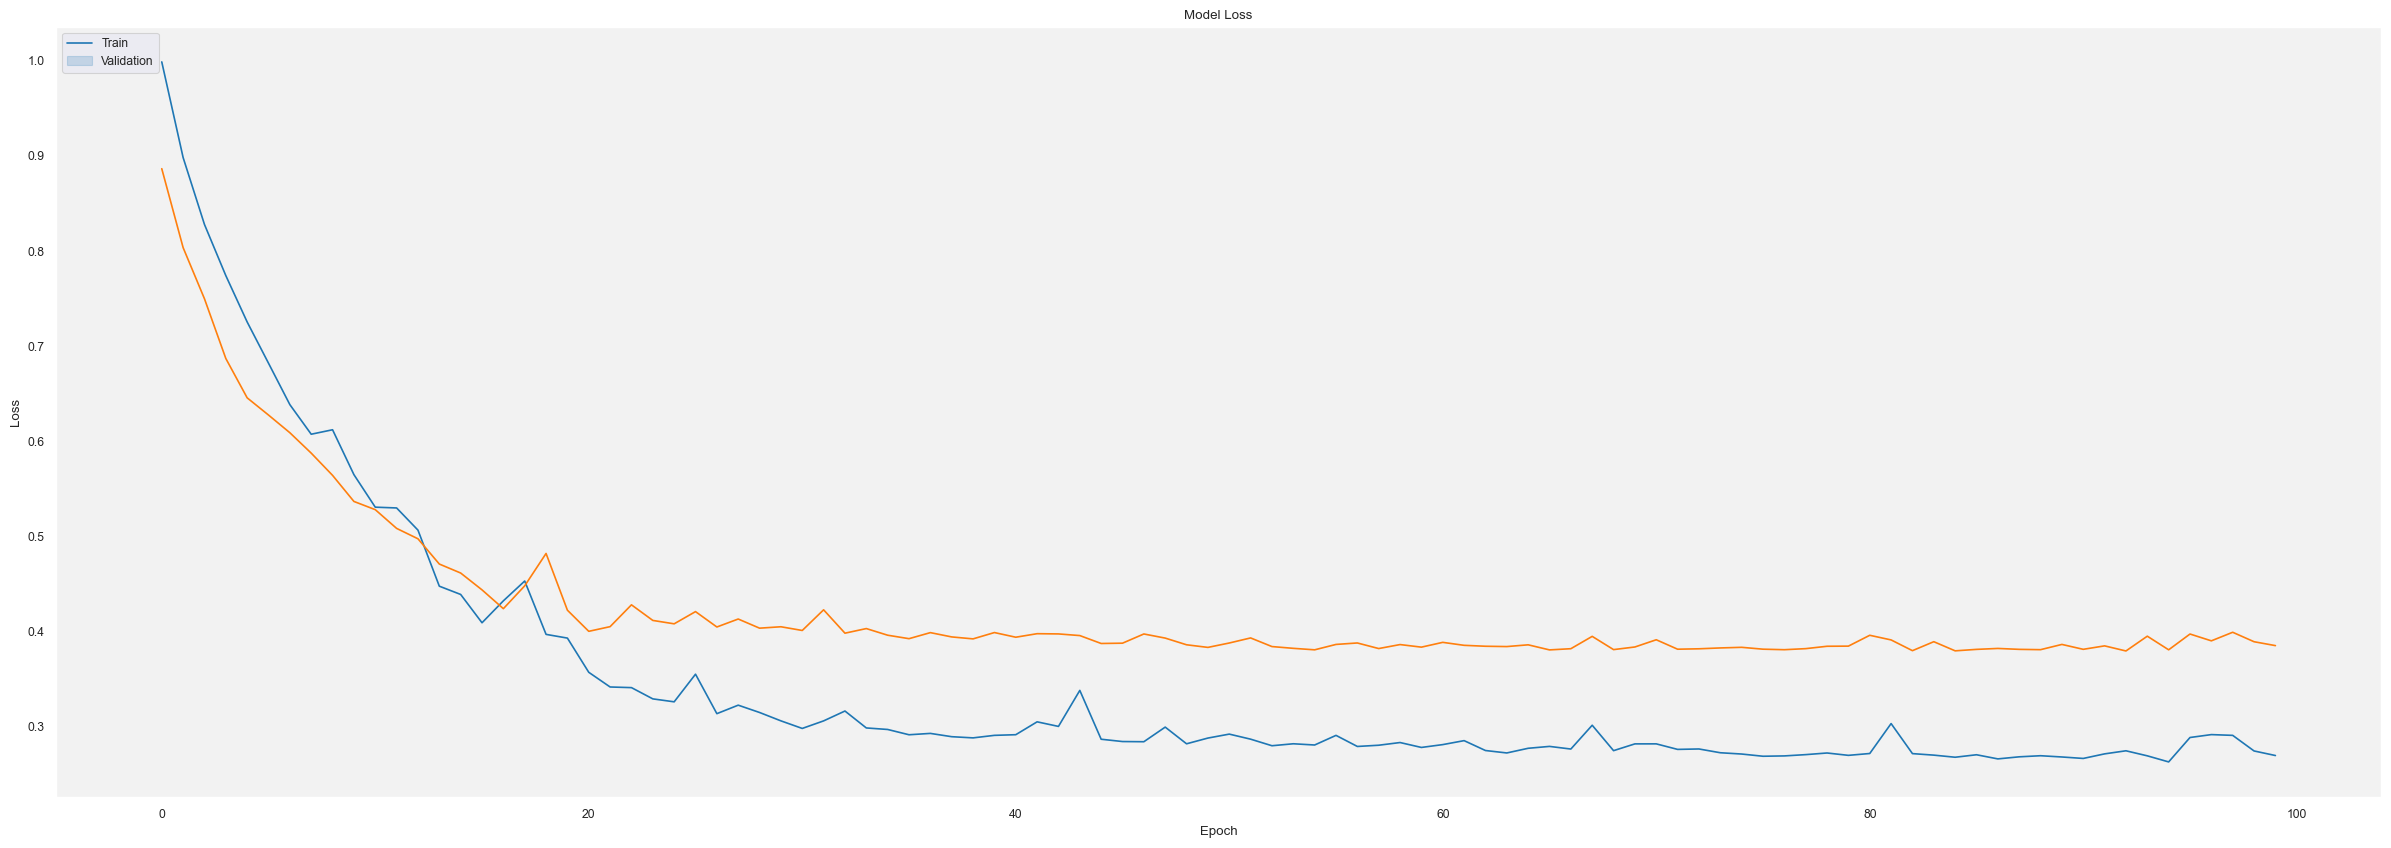

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("dark")
sns.set_context("paper")

plt.figure(figsize=(30, 10))
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')

ax = plt.gca()
ax.set_facecolor('#F2F2F2')

plt.show()

In [180]:
from sklearn.metrics import mean_squared_error

def rmse1(yt, yp): #lower the better
    return np.sqrt(mean_squared_error(yt, yp))

# Kling-Gupta effciency
def kge1(yt, yp): #highqer the better
    r = np.corrcoef(yt, yp,rowvar=False)[0, 1]
    alpha = np.std(yp) / np.std(yt)
    beta = np.mean(yp) / np.mean(yt)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

# Normalized standard Error
def nse1(yt, yp):
    return 1 - np.sum((yt - yp)**2) / np.sum((yt - np.mean(yt))**2)

# r squared
def r21(yt, yp): #higher the better
    return 1 - np.sum((yt - yp)**2) / np.sum((yt - np.mean(yt))**2)

In [181]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

3/3 [==============================] - 0s 13ms/step


In [182]:
y_pred_train.shape

(374, 1)

In [183]:
y_pred_train_inv = inv.inverse_transform(y_pred_train)
y_pred_test_inv = inv.inverse_transform(y_pred_test)
y_train__inv = observed_runnoff[:len(y_pred_train_inv)]
y_test__inv = observed_runnoff[len(y_pred_train_inv):]

In [184]:
from sklearn.metrics import r2_score

print("KGE train: ", round(kge1(y_train__inv, y_pred_train_inv),4))
print("KGE test: ", round(kge1(y_test__inv, y_pred_test_inv),4))


KGE train:  0.7587
KGE test:  0.7162


In [146]:
df_ssp = pd.read_csv('/Users/rahuljauhari/Desktop/research-runoff/Data/SSP_monthly_585.csv')
df_ssp['TimeDate'] = pd.to_datetime(df_ssp['TimeDate'])
df_ssp.set_index('TimeDate', inplace=True)
monthly_mean = df_ssp
print(monthly_mean.shape)
scaler = StandardScaler()
x,y,inv_scaler= func('StandardScaler',monthly_mean,observed_runnoff)
# y=scaler.fit_transform(observed_runnoff.values.reshape(-1,1))
print(x.shape)
y_pred = model.predict(x)
print(y_pred.shape)
y_inv = inv_scaler.inverse_transform(y_pred)
pd.DataFrame(y_inv).to_csv('SSP_monthly_585_flstm.csv',header=True)


(948, 156)
(948, 156)
30/30 [==============================] - 0s 13ms/step
(948, 1)


In [147]:
df_ssp = pd.read_csv('/Users/rahuljauhari/Desktop/research-runoff/Data/SSP_monthly_370.csv')
df_ssp['TimeDate'] = pd.to_datetime(df_ssp['TimeDate'])
df_ssp.set_index('TimeDate', inplace=True)
monthly_mean = df_ssp
print(monthly_mean.shape)
x,y,inv_scaler= func('StandardScaler',monthly_mean,observed_runnoff)
print(x.shape)
y_pred = model.predict(x)
print(y_pred.shape)
y_inv = inv_scaler.inverse_transform(y_pred)
pd.DataFrame(y_inv).to_csv('SSP_monthly_370_flstm.csv',header=True)


(948, 156)
(948, 156)
30/30 [==============================] - 0s 12ms/step
(948, 1)


In [152]:
df_ssp = pd.read_csv('/Users/rahuljauhari/Desktop/research-runoff/Data/SSP_monthly_245.csv')
df_ssp['DateTime'] = pd.to_datetime(df_ssp['DateTime'])
df_ssp.set_index('DateTime', inplace=True)
monthly_mean = df_ssp.resample('M').mea
print(monthly_mean.shape)
x,y,inv_scaler= func('StandardScaler',monthly_mean,observed_runnoff)
print(x.shape)
y_pred = model.predict(x)
print(y_pred.shape)
y_inv1 = inv_scaler.inverse_transform(y_pred)
pd.DataFrame(y_inv1).to_csv('SSP_monthly_245_flstm.csv',header=True)


(948, 156)
(948, 156)
30/30 [==============================] - 0s 11ms/step
(948, 1)


In [150]:
df_ssp = pd.read_csv('/Users/rahuljauhari/Desktop/research-runoff/Data/SSP_monthly_126.csv')
df_ssp['DateTime'] = pd.to_datetime(df_ssp['DateTime'])
df_ssp.set_index('DateTime', inplace=True)
monthly_mean = df_ssp
print(monthly_mean.shape)
x,y,inv_scaler= func('StandardScaler',monthly_mean,observed_runnoff)
print(x.shape)
y_pred = model.predict(x)
print(y_pred.shape)
y_inv = inv_scaler.inverse_transform(y_pred)
pd.DataFrame(y_inv).to_csv('SSP_monthly_126_flstm.csv',header=True)


(948, 156)
(948, 156)
30/30 [==============================] - 0s 13ms/step
(948, 1)
